# Ice Modeling



In [1]:
import mysg # Tom Robitaille's YSO grid tool
from astropy.table import Table
from astropy import units as u, constants
import pylab as pl
import requests

from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, atmo_model, molecule_data

In [99]:
from astroquery.svo_fps import SvoFps

In [100]:
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

In [2]:
xarr = np.linspace(1, 28, 15000)*u.um

In [3]:
phx4000 = atmo_model(4000)

In [4]:
nh3_consts = load_molecule('nh3')

In [5]:
co2_consts = load_molecule('co2')

(1.0, 25)

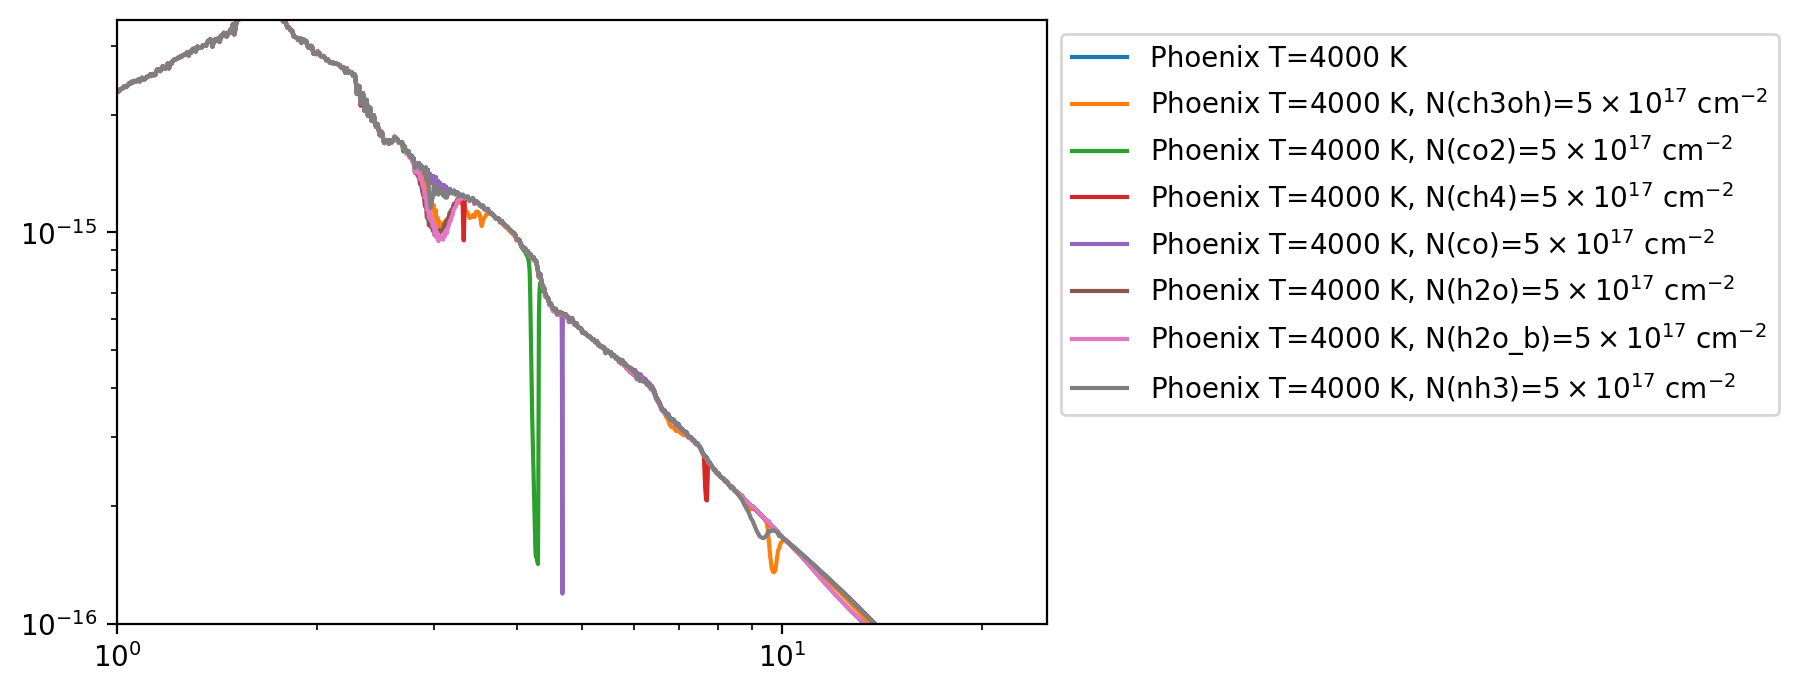

In [6]:
pl.figure(dpi=200)
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")

for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(5e17*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
              spec,
              label=f"Phoenix T=4000 K, N({molecule})=$5\\times10^{{17}}$ cm$^{{-2}}$")

pl.legend(bbox_to_anchor=[1.0, 1.0])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

In [7]:
from icemodels.gaussian_model_components import *

(1.0, 25)

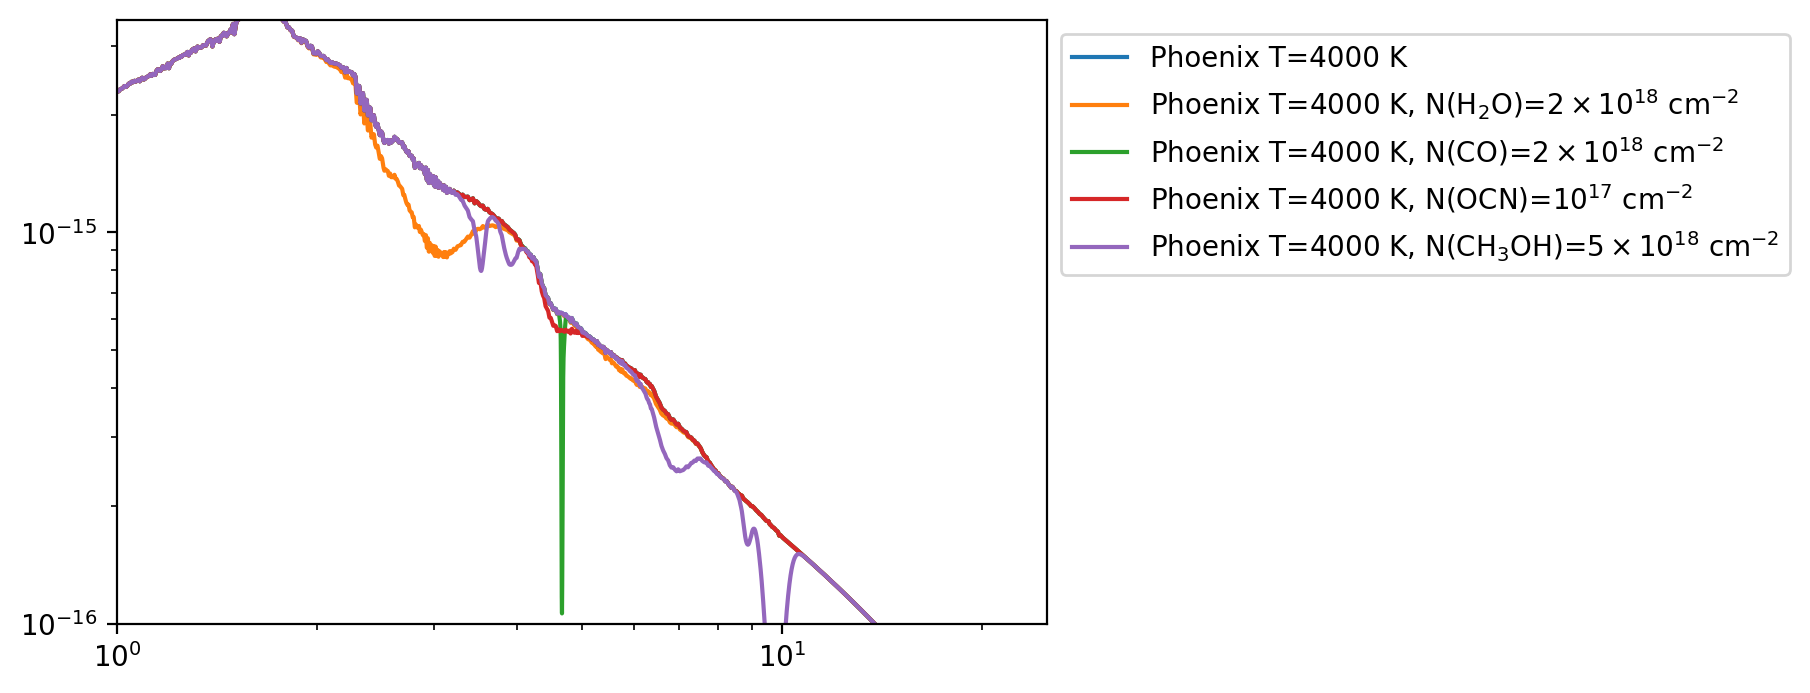

In [8]:
pl.figure(dpi=200)

pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(2e18*u.cm**-2, water_ice_centers, water_ice_widths, water_ice_bandstrengths),
          label="Phoenix T=4000 K, N(H$_2$O)=$2 \\times 10^{18}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(2e18*u.cm**-2, co_ice_centers, co_ice_widths, co_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CO)=$2 \\times 10^{18}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(2e17*u.cm**-2, ocn_center, ocn_width, ocn_bandstrength),
          label="Phoenix T=4000 K, N(OCN)=10$^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(5e18*u.cm**-2, methanol_ice_centers, methanol_ice_widths, methanol_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CH$_3$OH)=$5\\times10^{18}$ cm$^{-2}$")
#pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
#          absorbed_spectrum2(5e18*u.cm**-2, co2_consts),
#          label="Phoenix T=4000 K, N(CO$_2$)=$5\\times10^{18}$ cm$^{-2}$")


pl.legend(bbox_to_anchor=[1,1])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

(1.0, 25)

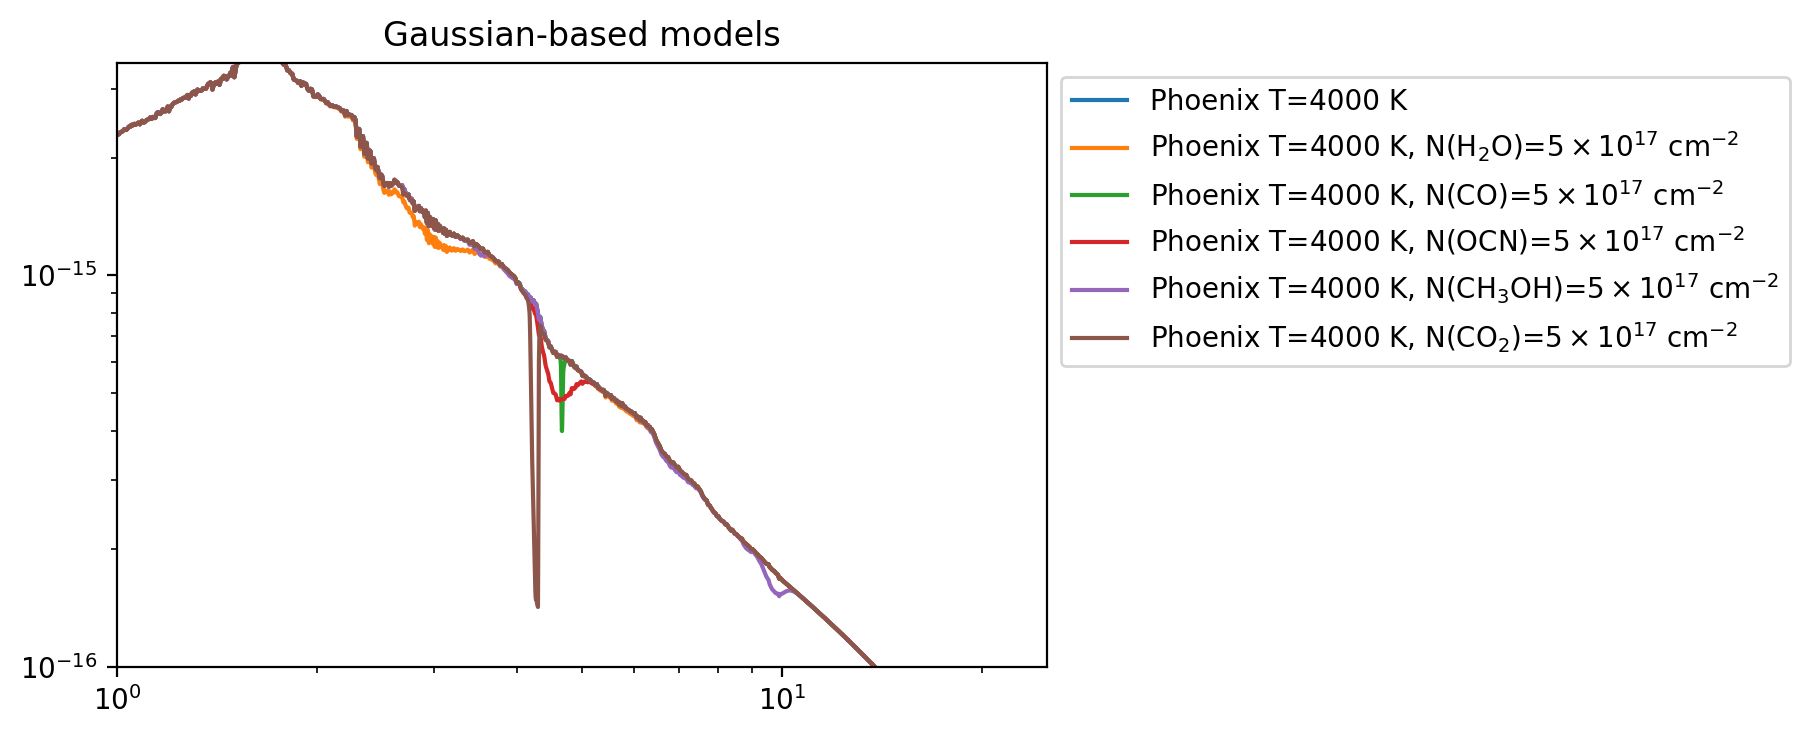

In [9]:
pl.figure(dpi=200)

pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(5e17*u.cm**-2, water_ice_centers, water_ice_widths, water_ice_bandstrengths),
          label="Phoenix T=4000 K, N(H$_2$O)=$5 \\times 10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(5e17*u.cm**-2, co_ice_centers, co_ice_widths, co_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CO)=$5 \\times 10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(5e17*u.cm**-2, ocn_center, ocn_width, ocn_bandstrength),
          label="Phoenix T=4000 K, N(OCN)=$5 \\times 10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(5e17*u.cm**-2, methanol_ice_centers, methanol_ice_widths, methanol_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CH$_3$OH)=$5\\times10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum(5e17*u.cm**-2, co2_consts),
          label="Phoenix T=4000 K, N(CO$_2$)=$5\\times10^{17}$ cm$^{-2}$")

pl.title("Gaussian-based models")
pl.legend(bbox_to_anchor=[1,1])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

(1.0, 25)

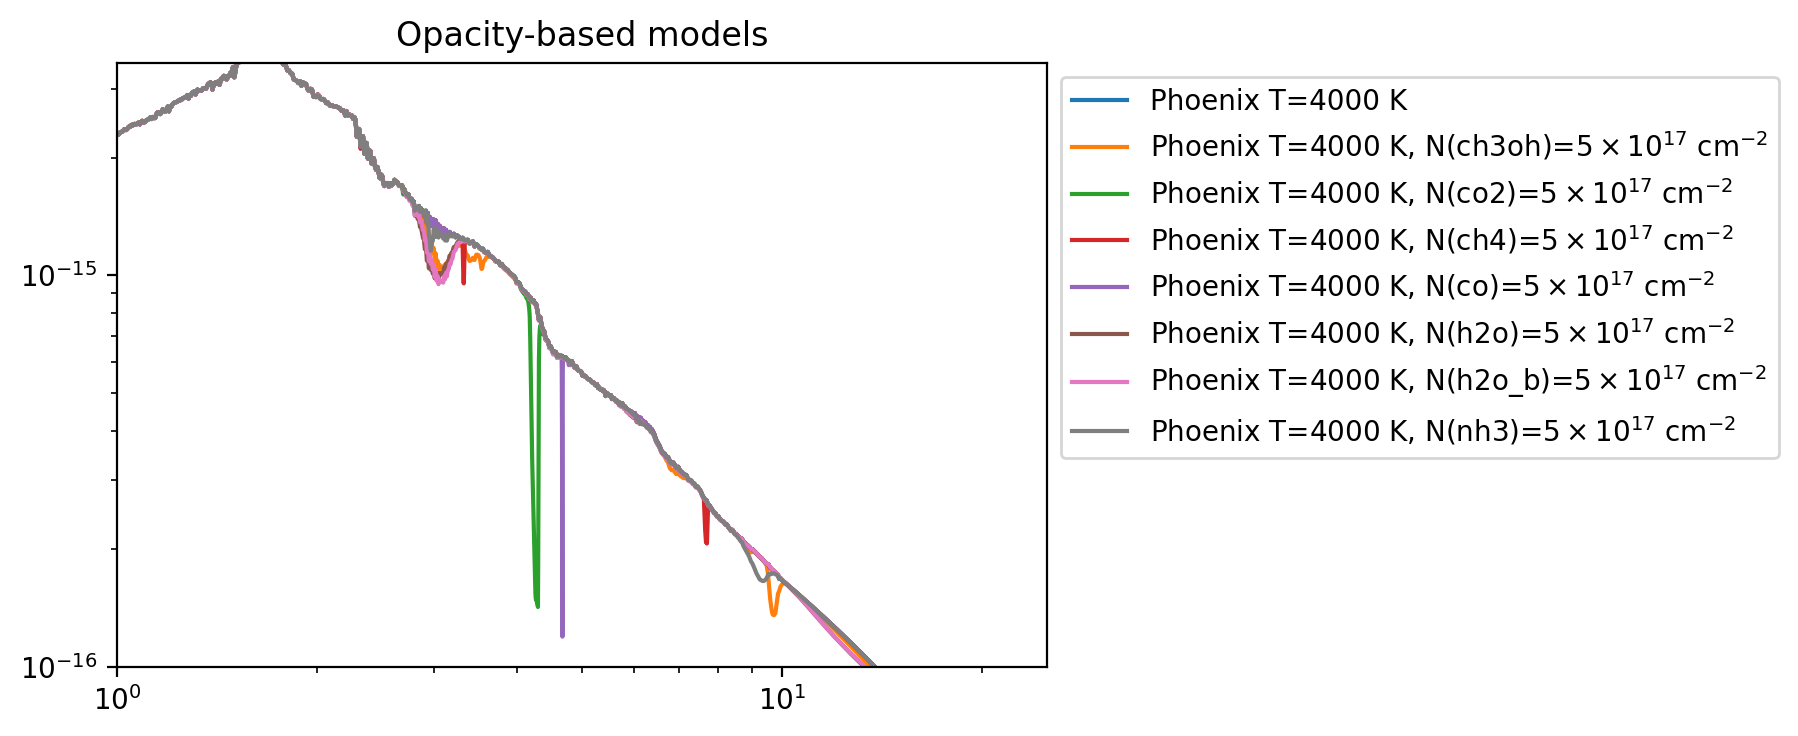

In [10]:
pl.figure(dpi=200)
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")

for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(5e17*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
              spec,
              label=f"Phoenix T=4000 K, N({molecule})=$5\\times10^{{17}}$ cm$^{{-2}}$")
pl.title("Opacity-based models")

pl.legend(bbox_to_anchor=[1.0, 1.0])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

(1.0, 25)

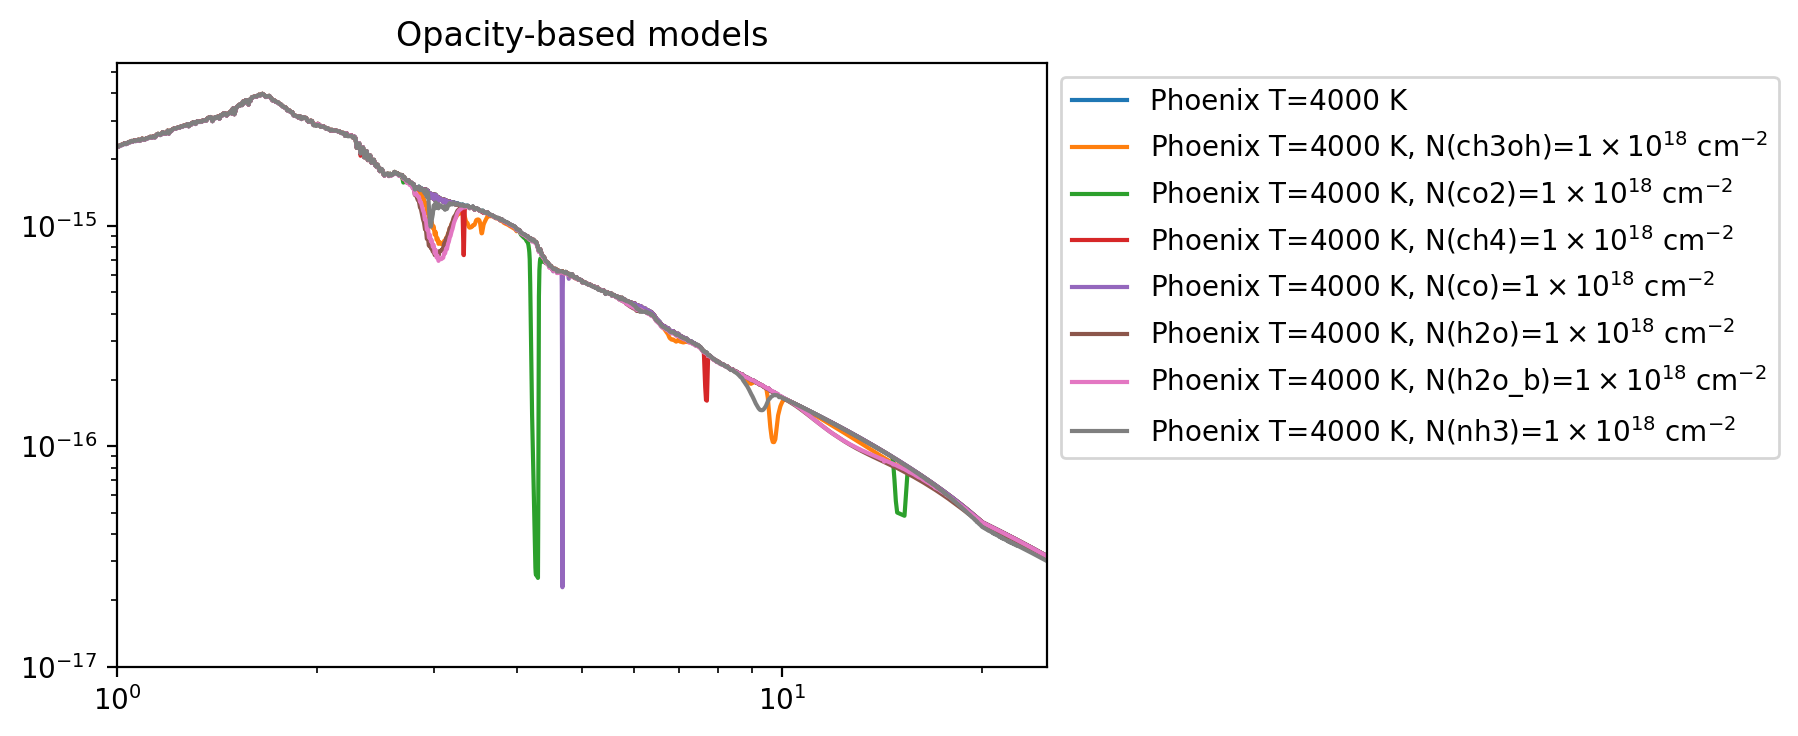

In [11]:
pl.figure(dpi=200)
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")

for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
              spec,
              label=f"Phoenix T=4000 K, N({molecule})=$1\\times10^{{18}}$ cm$^{{-2}}$")
pl.title("Opacity-based models")

pl.legend(bbox_to_anchor=[1.0, 1.0])
pl.ylim(1e-17, 5.5e-15)
pl.xlim(1.0, 25)

In [12]:
cmds = [(('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N'),
         ('JWST/NIRCam.F115W', 'JWST/NIRCam.F200W')),
        (('JWST/NIRCam.F300M', 'JWST/NIRCam.F356W'),
         ('JWST/NIRCam.F466N', 'JWST/NIRCam.F444W')),
        (('JWST/MIRI.F560W', 'JWST/MIRI.F770W'),
         ('JWST/MIRI.F1000W', 'JWST/MIRI.F1130W')),
        (('JWST/MIRI.F1280W', 'JWST/MIRI.F1500W'),
         ('JWST/MIRI.F1800W', 'JWST/MIRI.F2100W')),
       ]

In [13]:
import matplotlib

In [14]:
temperatures = (2000, 3000, 4000, 5000, 7000, 10000)

tmods = {temperature: atmo_model(temperature)
         for temperature in temperatures}

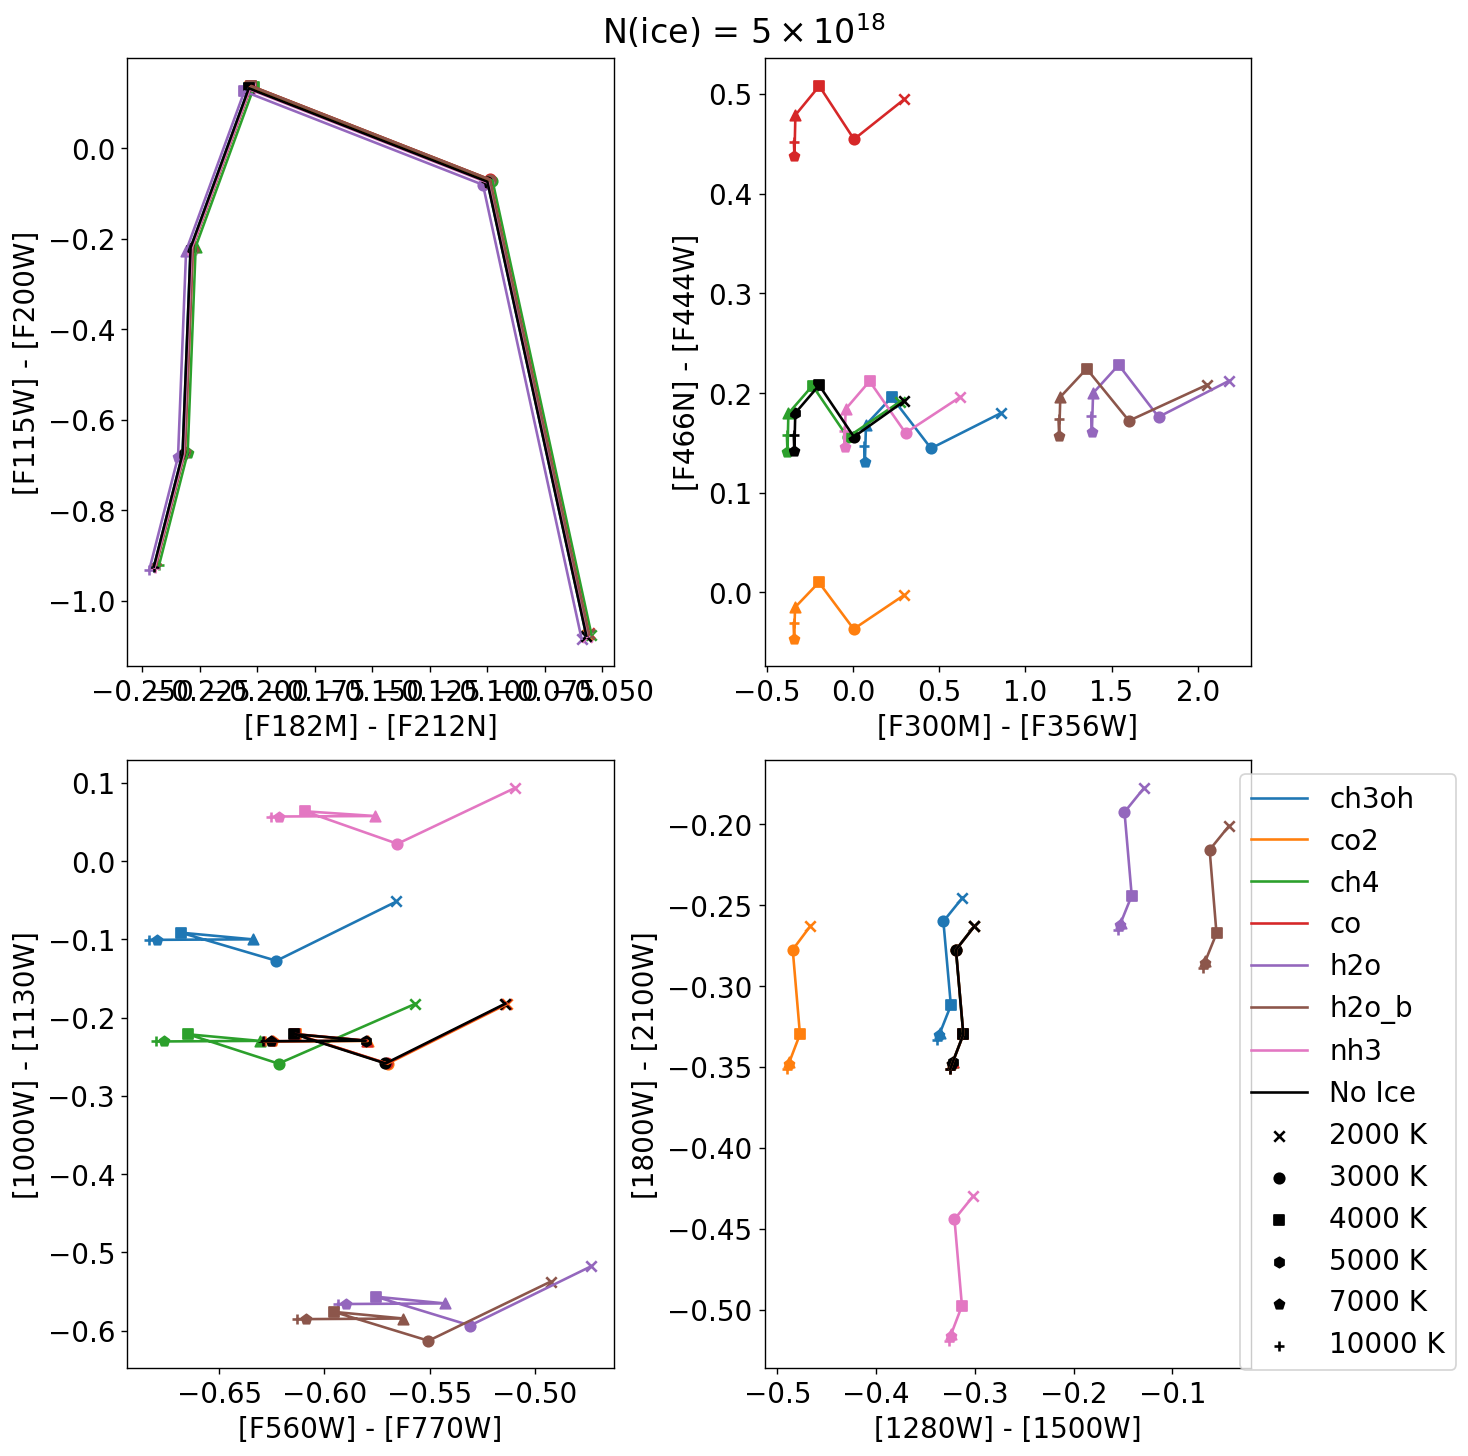

In [15]:
pl.figure(figsize=(12, 12), dpi=125)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())


with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(cmds):
        ax = pl.subplot(2, 2, ii+1)
        ax.set_xlabel(f'[{cmd_x[0][-5:]}] - [{cmd_x[1][-5:]}]')
        ax.set_ylabel(f'[{cmd_y[0][-5:]}] - [{cmd_y[1][-5:]}]')

        
        for molecule, moldata in molecule_data.items():
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            for temperature in temperatures:
                xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
                spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=md['molwt'],
                                          spectrum=tmods[temperature]['fnu'].quantity,
                                          xarr=xarr,
                                         )

                flxd = fluxes_in_filters(xarr, spec)
                mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
                mags_y = flxd[cmd_y[0]].to(u.ABmag).value, flxd[cmd_y[1]].to(u.ABmag).value
                xdata.append(mags_x[0]-mags_x[1])
                ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=molecule)
            #print(xdata, ydata)
            for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
                ax.scatter(xx, yy, marker=marker, color=L.get_color())
                #print(xx, yy)

        xdata = []
        ydata = []
        for temperature in temperatures:
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            flxd = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
            mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
            mags_y = flxd[cmd_y[0]].to(u.ABmag).value, flxd[cmd_y[1]].to(u.ABmag).value
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
        ax.plot(xdata, ydata, label='No Ice', color='k')
        for marker, temperature, xx, yy in zip('xoshp+', temperatures, xdata, ydata):
            ax.scatter(xx, yy, marker=marker, color='k', label=f'{temperature} K')
        

    pl.legend(loc='upper right', bbox_to_anchor=[1.45,1.0])
    pl.suptitle("N(ice) = $5\\times10^{18}$")
pl.tight_layout()

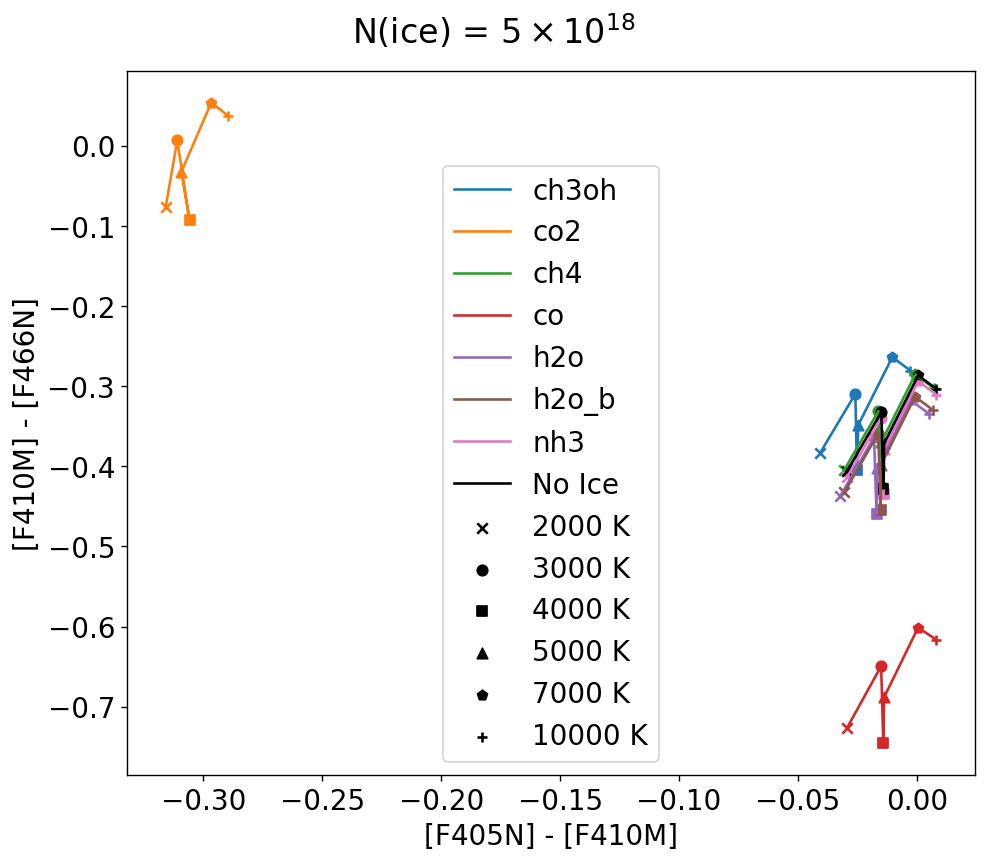

In [16]:
ccds2 = [
    (('JWST/NIRCam.F405N', 'JWST/NIRCam.F410M'),
     ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')),
# no ice    (('JWST/NIRCam.F187N', 'JWST/NIRCam.F182M'),
# no ice     ('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N')),

]    
pl.figure(figsize=(8, 7), dpi=125)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())


with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(ccds2):
        ax = pl.subplot(1, 1, ii+1)
        ax.set_xlabel(f'[{cmd_x[0][-5:]}] - [{cmd_x[1][-5:]}]')
        ax.set_ylabel(f'[{cmd_y[0][-5:]}] - [{cmd_y[1][-5:]}]')

        
        for molecule, moldata in molecule_data.items():
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            for temperature in temperatures:
                xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
                spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=md['molwt'],
                                          spectrum=tmods[temperature]['fnu'].quantity,
                                          xarr=xarr,
                                         )

                flxd = fluxes_in_filters(xarr, spec)
                mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
                mags_y = flxd[cmd_y[0]].to(u.ABmag).value, flxd[cmd_y[1]].to(u.ABmag).value
                xdata.append(mags_x[0]-mags_x[1])
                ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=molecule)
            #print(xdata, ydata)
            for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
                ax.scatter(xx, yy, marker=marker, color=L.get_color())
                #print(xx, yy)

        xdata = []
        ydata = []
        for temperature in temperatures:
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            flxd = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
            mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
            mags_y = flxd[cmd_y[0]].to(u.ABmag).value, flxd[cmd_y[1]].to(u.ABmag).value
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
        ax.plot(xdata, ydata, label='No Ice', color='k')
        for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
            ax.scatter(xx, yy, marker=marker, color='k', label=f'{temperature} K')
        

    pl.legend(loc='best')#upper right', bbox_to_anchor=[1.45,1.0])
    pl.suptitle("N(ice) = $5\\times10^{18}$")
pl.tight_layout()    